In [ ]:
# colab setup
import os
import subprocess as sp
import sys
from pathlib import Path

from rich.console import Console

console = Console()

# --- Colab detection ---
try:
    import google.colab  # noqa

    IS_COLAB = True
except ImportError:
    IS_COLAB = False

REPO = "https://github.com/haeussma/chromhandler-example.git"
BRANCH = "main"

# --- Colab-only repo setup ---
if IS_COLAB:
    base = Path("/content")
    name = Path(REPO).name.removesuffix(".git")
    dest = base / name
    if dest.exists():
        sp.run(["git", "-C", str(dest), "fetch", "origin", BRANCH], check=True)
        sp.run(["git", "-C", str(dest), "checkout", BRANCH], check=True)
        sp.run(
            ["git", "-C", str(dest), "reset", "--hard", f"origin/{BRANCH}"], check=True
        )
    else:
        sp.run(
            ["git", "clone", "--depth", "1", "--branch", BRANCH, REPO, str(dest)],
            check=True,
        )
    if Path.cwd().resolve() != dest.resolve():
        os.chdir(dest)
    console.log(f"Current directory: [bold]{Path.cwd()}[/]")
else:
    pass

# --- Colab-only install ---
if IS_COLAB:
    cmd = [
        sys.executable,
        "-m",
        "pip",
        "install",
        "chromhandler>=0.10.2",
        "ipywidgets>=8.1.7",
        "ipykernel>=6.30.1",
        "git+https://github.com/JR-1991/Catalax@master",
    ]
    with console.status("[bold green]Installing packages…[/]", spinner="dots"):
        sp.run(cmd, check=True)
else:
    pass

# --- Import with friendly error ---
try:
    import chromhandler as ch  # noqa: F401
except ImportError as e:
    console.print(f"[bold red]ImportError:[/] {e}")
    console.print(
        "[red]If this was a fresh install in Colab/Jupyter, restart the kernel and run the cell again.[/]"
    )
    raise

# Processing chromatographic calibration data

In [1]:
# import chromhandler
import chromhandler as ch

In this project, HPLC data have already been integrated, and the resulting files are organized in `data/hplc/`. Each subfolder contains the peak tables for `adenosine` and `adenine`.

In the following cell, metadata on the measurement conditions are defined, and the calibration data for `adenosine` are loaded.

In [10]:
# path to adenosine calibration data
adenosine_path = "data/hplc/calibration/adenosine"

# parameters
ph = 7.4
temp = 37
temp_unit = "deg_C"

# initialize handler
handler = ch.Handler.read_asm(
    path=adenosine_path,
    ph=ph,
    temperature=temp,
    temperature_unit=temp_unit,
    mode="calibration",
)

# show state of handler
handler

Loaded 6 chromatograms.



╭─ 📋 Handler Overview ───────────────────────────────────────────────────────────────────────────────────────────╮
│ ID: adenosine                                                                                                   │
│ Name: Chromatographic measurement                                                                               │
│ Mode: calibration                                                                                               │
│ Measurements: 6                                                                                                 │
│ Peak Assignment: 0/11 (0.0%)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

 📊 Component Statistics  
┏━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Component      ┃ Count ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Molecules      │     0 │
│ Proteins       │     0 │
│ Measurements   │     6 │

Once the handler is initialized, you can visualize the chromatogram. Adjust `rt_min` and `rt_max` to zoom into the relevant retention time window. Adenosine is expected to elute between 7.82.


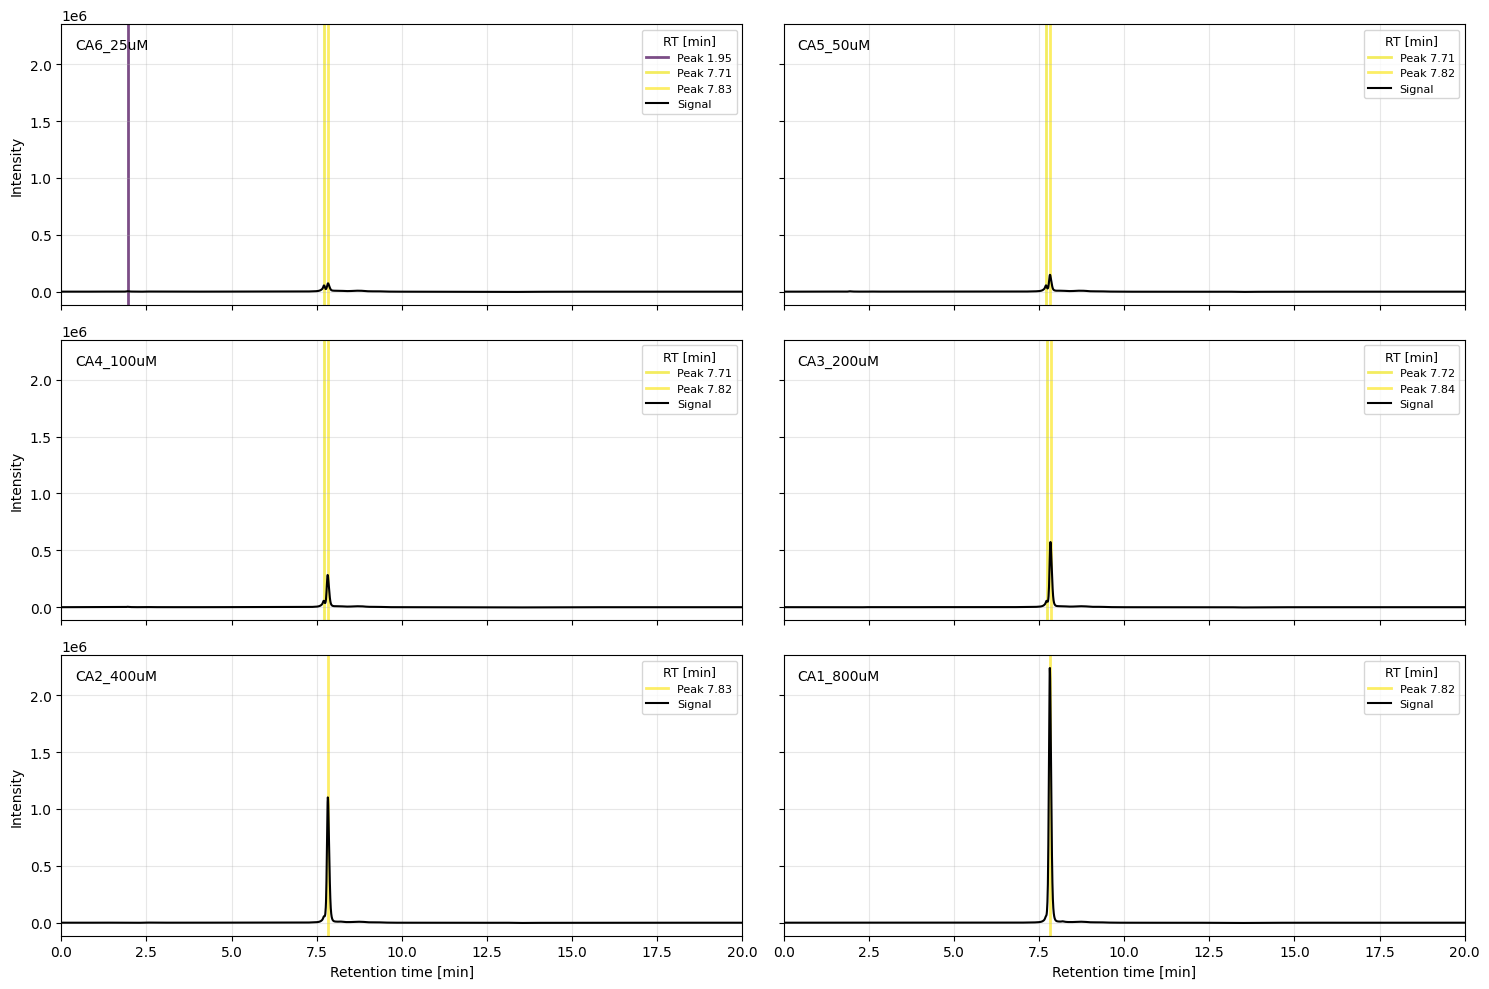

In [13]:
# visualize all chromatograms and peaks
handler.visualize(rt_min=0, rt_max=20)

In the next cell, `adenosine` is defined as a `Molecule` object and added to the handler.

           🎯 Peak Assignment Summary of adenosine           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Molecule              ┃   Status   ┃ Details              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ adenosine (adenosine) │ ✅ Success │ (6/6) peaks assigned │
└───────────────────────┴────────────┴──────────────────────┘

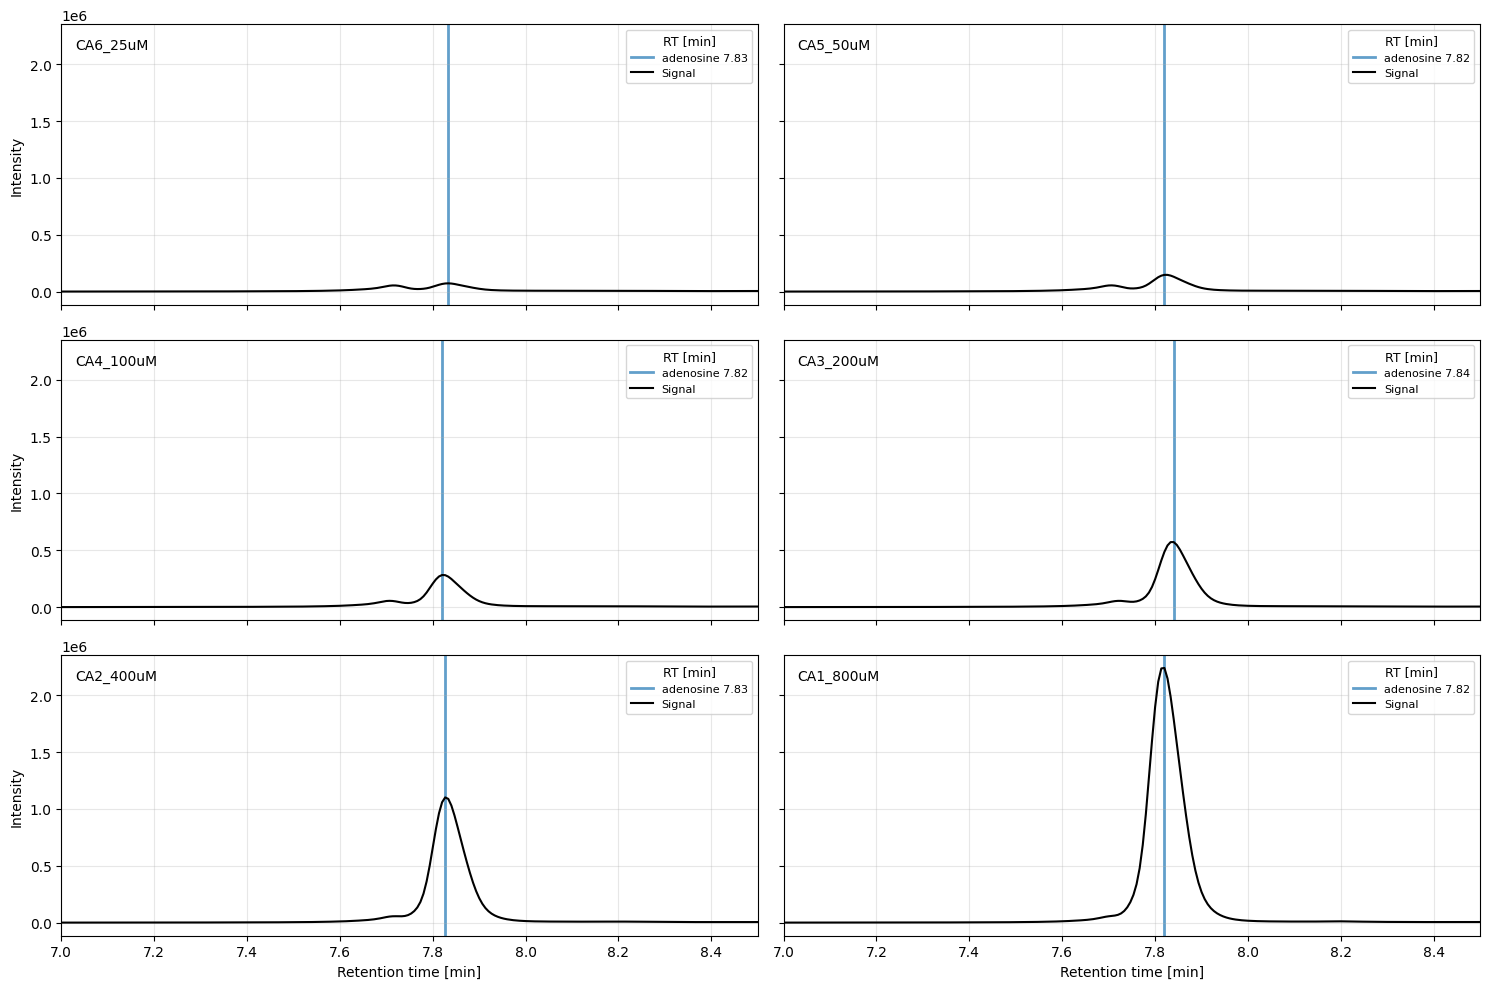

In [4]:
# define adenosine with retention time
adenosine = ch.Molecule(
    id="adenosine",
    name="adenosine",
    pubchem_cid=60961,
    retention_time=7.82,
    retention_tolerance=0.05,
)

init_conc = 300
conc_unit = "umol / L"

# add molecule to handler with initial concentration
handler.add_molecule(
    molecule=adenosine,
    init_conc=init_conc,
    conc_unit=conc_unit,
)

# assign molecules to peaks
handler.assign_all_peaks()

# verify assignment
handler.visualize(rt_min=7, rt_max=8.5, assigned_only=True)

Next up, create the standard curve for `adenosine` by calling `add_standard`. This fits a linear model to the calibration measurements and stores the fitted model with the molecule.


✅ Models have been successfully fitted.


                                           Model Overview                                            
┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC ┃ R squared ┃ RMSD          ┃ Equation      ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ 198 │ 1.0       │ 12256879.6314 │ adenosine * a │ a: 0.2%,                           │
└────────────┴─────┴───────────┴───────────────┴───────────────┴────────────────────────────────────┘

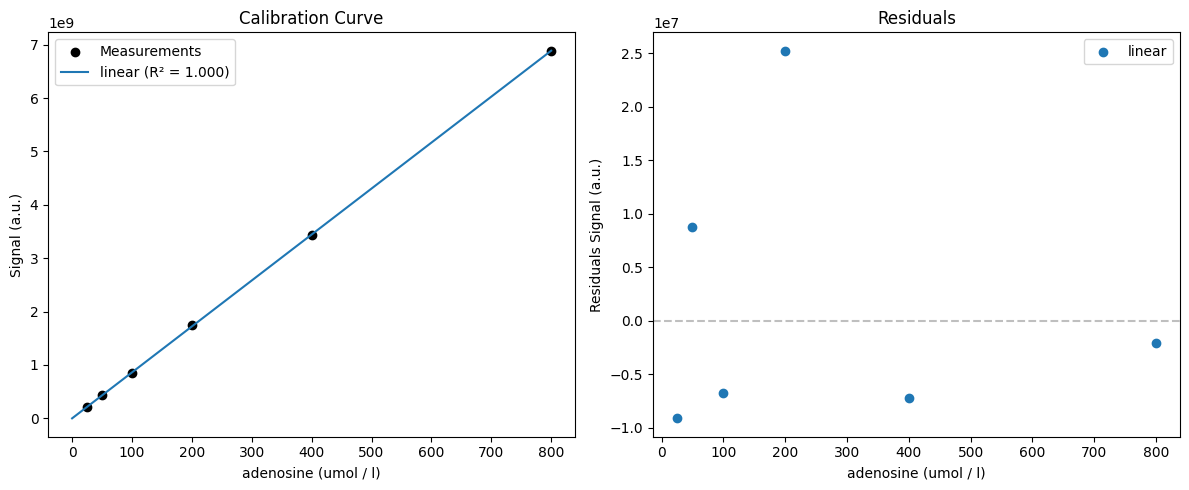

In [5]:
# create standard curve for adenosine
handler.add_standard(molecule=adenosine)

Finally, `adenosine` is saved to a file, so it can be used in the next notebook in which time course data is processed.

In [6]:
# save molecule to file
adenosine.save_json("data/molecules/adenosine.json")

## 🧪 Now you: repeat the same steps for `adenine`

The retention time of adenine should be somewhere between 9 and 10 minutes. Use the visualize method to locate the peak and find a sensible retention time.

In [7]:
adenine_path = "data/hplc/calibration/adenine"

# ...

### Enzymes

As Molecules, proteins can also be pre-created for later use. In the next notbook `2-kinetic.ipynb` we will use the `SAHH` enzyme, together with the molecules `adenosine` and `adenine` to create an EnzymeML Document.

In [8]:
SAHH = ch.Protein(
    id="Q8NSC4",
    name="SAHH",
    sequence="MDFKVADLSLAEAGRHQIRLAEYEMPGLMQLRKEFADEQPLKGARIAGSIHMTVQTAVLIETLTALGAEVRWASCNIFSTQDEAAAAIVVGSGTVEEPAGVPVFAWKGESLEEYWWCINQIFSWGDELPNMILDDGGDATMAVIRGREYEQAGLVPPAEANDSDEYIAFLGMLREVLAAEPGKWGKIAEAVKGVTEETTTGVHRLYHFAEEGVLPFPAMNVNDAVTKSKFDNKYGTRHSLIDGINRATDMLMGGKNVLVCGYGDVGKGCAEAFDGQGARVKVTEADPINALQALMDGYSVVTVDEAIEDADIVITATGNKDIISFEQMLKMKDHALLGNIGHFDNEIDMHSLLHRDDVTRTTIKPQVDEFTFSTGRSIIVLSEGRLLNLGNATGHPSFVMSNSFADQTIAQIELFQNEGQYENEVYRLPKVLDEKVARIHVEALGGQLTELTKEQAEYIGVDVAGPFKPEHYRY",
)

SAHH.save_json("data/proteins/SAHH.json")


## ✅ All done!

Continue with the next notebook.